#### GPU / CPU Device

In [1]:
import torch


device = torch.device('cpu')

if torch.cuda.is_available():

    device = torch.device('cuda')

#### Caltech-UCSD Birds 200

Wah C., Branson S., Welinder P., Perona P., Belongie S. “The Caltech-UCSD Birds-200-2011 Dataset.” Computation & Neural Systems Technical Report, CNS-TR-2011-001.

In [2]:
import os
import wget
import shutil


if not os.path.exists('./CUB_200_2011.tgz'):
    wget.download(
        'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    )

if not os.path.exists('./CUB_200_2011'):
    shutil.unpack_archive('./CUB_200_2011.tgz')

    
data_dir = './CUB_200_2011'
images_dir = os.path.join(
    data_dir,
    'images'
)

ReadError: ./CUB_200_2011.tgz is not a compressed or uncompressed tar file

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

file_images = open(os.path.join(data_dir, 'images.txt'))
file_bboxes = open(os.path.join(data_dir, 'bounding_boxes.txt'))

list_images = file_images.readlines()
list_bboxes = file_bboxes.readlines()


def visualize_image(idx):
    image_path = os.path.join(
        images_dir,
        (list_images[idx].split(' ')[1]).strip('\n')
    )

    image_bbox = list_bboxes[idx].strip('\n').split(' ')
    minc = int(float(image_bbox[1]))
    minr = int(float(image_bbox[2]))
    maxc = int(float(image_bbox[3]))
    maxr = int(float(image_bbox[4]))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(plt.imread(image_path))

    rect = mpatches.Rectangle(
        (minc, minr),
        maxc - minc,
        maxr - minr,
        fill=False,
        edgecolor='green',
        linewidth=2
    )

    ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show();

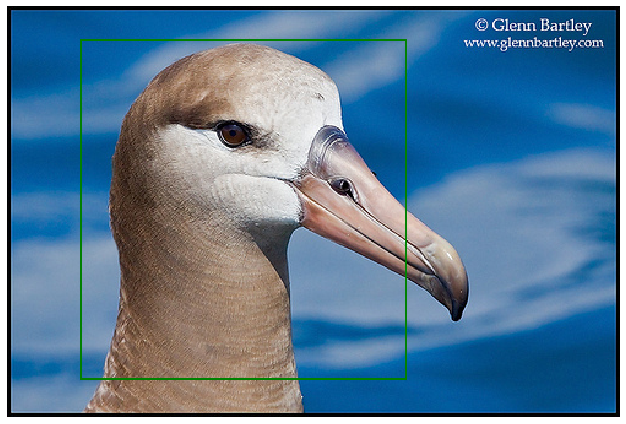

In [4]:
visualize_image(0)

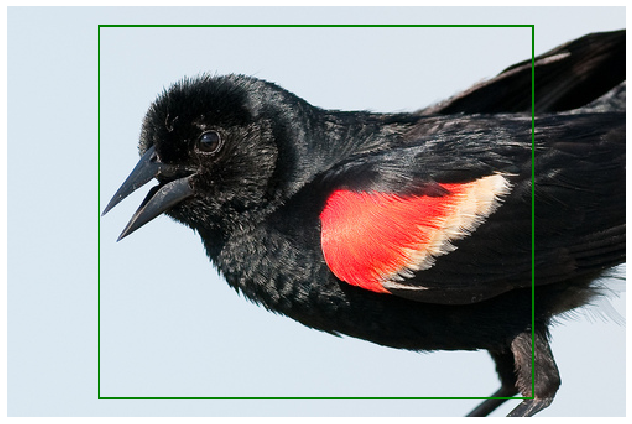

In [5]:
visualize_image(500)

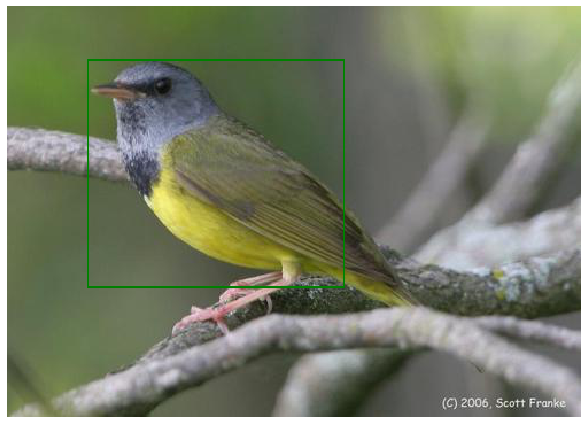

In [6]:
visualize_image(10000)

In [7]:
del file_bboxes
del file_images
del list_bboxes
del list_images

#### Visualize Dataset Balance

In [8]:
freqs = []
lbls = []


dirs = os.listdir(images_dir)

for directory in dirs:
    
    dir_pth = os.path.join(images_dir, directory)
    
    lbls.append(directory)
    freqs.append(
        len(
            os.listdir(dir_pth)
        )
    )

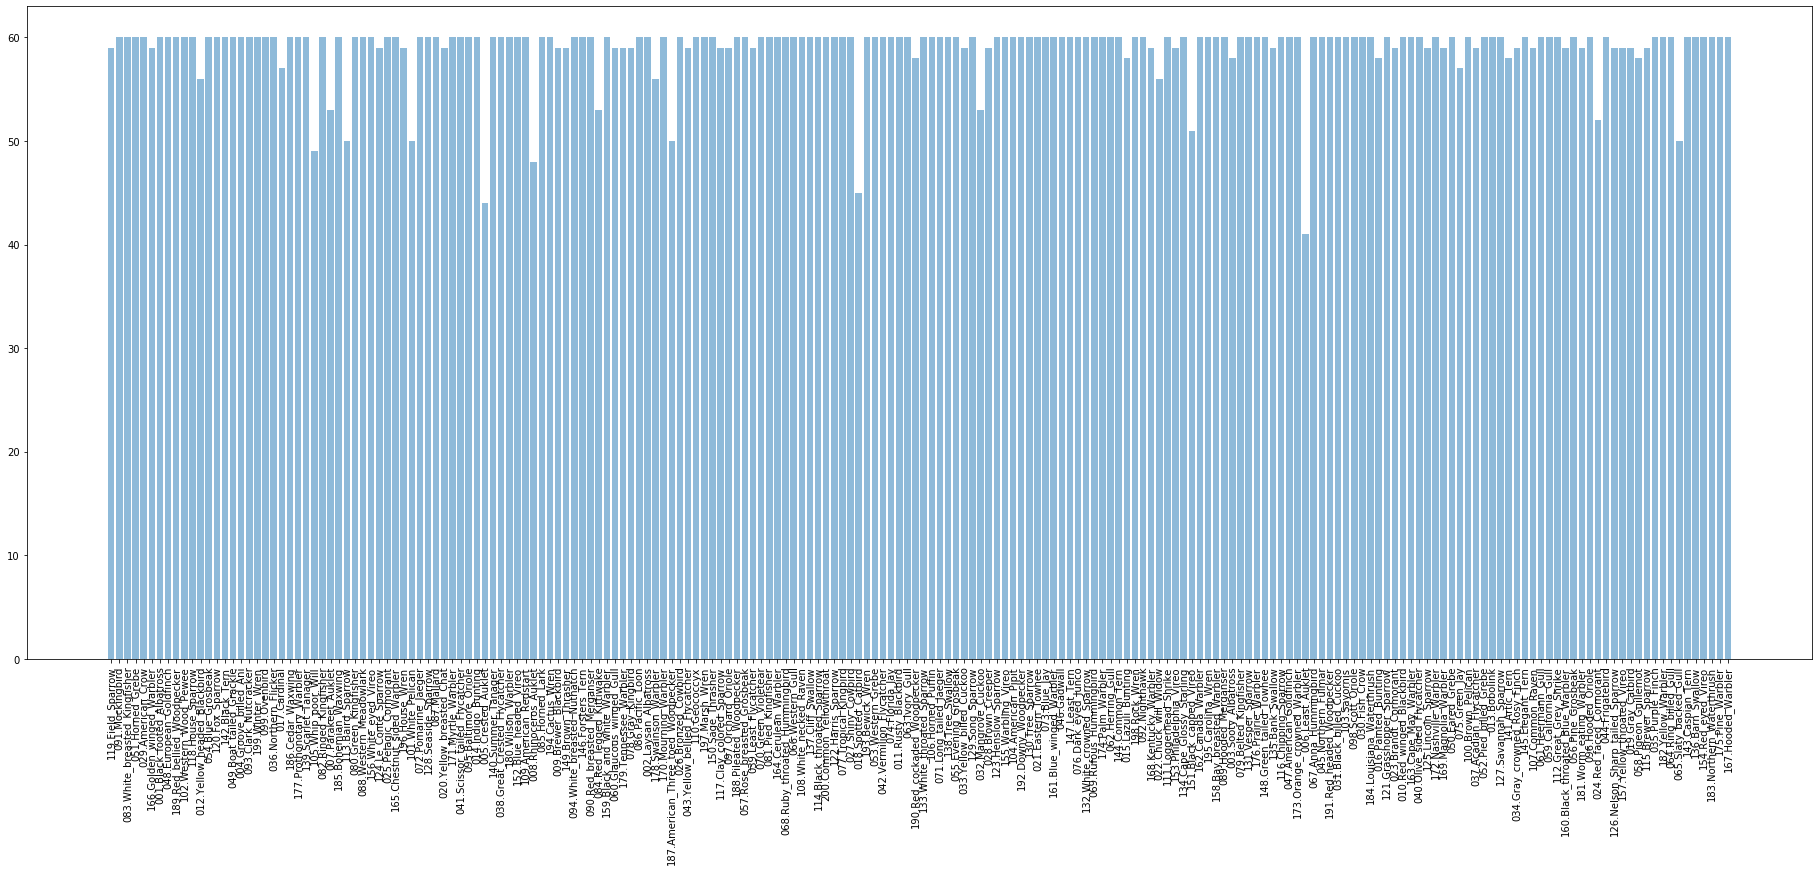

In [9]:
import numpy as np


plt.figure(figsize=(32, 12))

y_pos = np.arange(len(lbls))

plt.bar(y_pos, freqs, align='center', alpha=0.5)

plt.xticks(y_pos, lbls, rotation=90)

plt.show();

In [10]:
max_freq = np.max(freqs)

max_freq

60

#### Resize on Disk

In [11]:
from skimage.transform import resize
from skimage import io
from tqdm import tqdm
import numpy as np
from skimage.util import img_as_ubyte


# global variables
mini_dir = 'mini-birds'
bool_minify = True  # change to true


# execute this code only once
if bool_minify:

    # check directory exists
    if not os.path.exists(mini_dir):
    
        # create mini-birds dataset directory
        os.mkdir(mini_dir)

    # first 10 directories
    directories = os.listdir(images_dir)
    
    # loop sentinent
    loop_counter = 0
    
    # loop directories
    for i, directory in enumerate(directories):
        
        # stop after 10
        if loop_counter == 10:
            break

        # bookmark original directory
        source_dir = os.path.join(images_dir, directory)
        
        # check frequency
        if max_freq > len(os.listdir(source_dir)):
            continue
        else:
            loop_counter += 1
        
        # bookmark destination directory
        target_dir = os.path.join(mini_dir, directory)
        
        # create target directory
        if not os.path.exists(target_dir):
            os.mkdir(target_dir)
        
        # list files inside category
        images_files = os.listdir(source_dir)

        # init progress bar
        pbar = tqdm(total=len(images_files))
        
        # loop images inside each directory
        for image_file in images_files:
            
            # read image
            image = io.imread(
                os.path.join(source_dir, image_file)
            )
            
            # resize image and save
            new_image = resize(image, (64, 64), anti_aliasing=True)
            
            # suppress image type warning
            new_image = img_as_ubyte(new_image)
            
            # save image
            io.imsave(
                os.path.join(target_dir, image_file),
                new_image
            )
            
            # update progress bar
            pbar.update(1)
        
        # end progress bar
        pbar.close()

  0%|          | 0/60 [00:00<?, ?it/s]/home/mustafa/.local/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 60/60 [00:02<00:00, 23.80it/s]


#### Data Preprocessing

In [12]:
import torchvision


class SquashTransform:

    def __call__(self, inputs):
        return 2 * inputs - 1


data_train = torchvision.datasets.ImageFolder(
    mini_dir,
    transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize((64, 64)),
        torchvision.transforms.ToTensor(),
        SquashTransform()
    ])
)

In [13]:
from math import ceil


BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

num_steps = ceil(600 / BATCH_SIZE)

num_steps

5

#### Visualize Preprocessed Dataset

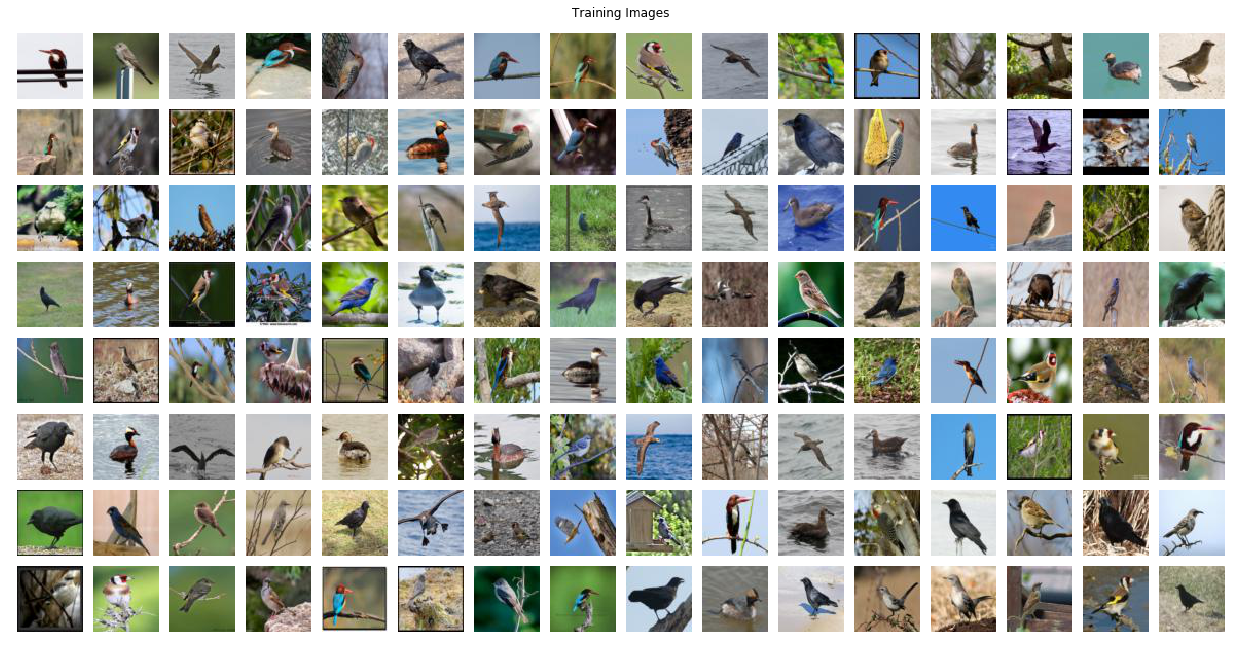

In [14]:
# Plot some training images
import numpy as np
from math import sqrt


real_batch = next(iter(train_loader))


plt.figure(figsize=(22, 12))
plt.axis("off")
plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device),
            padding=10,
            normalize=True,
            pad_value=1,
            nrow=int(3 * sqrt(BATCH_SIZE) / 2)
        ).cpu(),
        (1,2,0)
    )
);


#### Global Dimensions

In [15]:
# Number of channels in the training images.
# For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

#### Generator Design

Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [16]:
class Generator(torch.nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 8
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 4
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 2
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

#### Discriminator Design

In [17]:
class Discriminator(torch.nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 2
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 4
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 8
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

#### Weight Initialization

In [18]:
# custom weights initialization called on netG and netD
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
netD = Discriminator().to(device)
netG = Generator().to(device)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#### Optimizer

In [19]:
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

In [20]:
criterion = torch.nn.BCELoss()

fixed_noise = torch.randn(
    25, nz, 1, 1
).to(device)

real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

#### Train Discriminator

In [21]:
def trainD(images):

    real_images = images.to(device)

    fake_images = netG(
        torch.randn(
            BATCH_SIZE, nz, 1, 1
        ).to(device)
    )

    optimizerD.zero_grad()

    real_outputs = netD(real_images)
    fake_outputs = netD(fake_images)

    d_x = criterion(real_outputs, real_labels)
    d_g_z = criterion(fake_outputs, fake_labels)

    d_x.backward()
    d_g_z.backward()

    optimizerD.step()

    loss = d_x + d_g_z
    
    return loss


#### Train Generator

In [22]:
def trainG():
    z = torch.randn(
        BATCH_SIZE, nz, 1, 1
    ).to(device)

    netG.zero_grad()

    outputs = netD(
        netG(z)
    )

    loss = criterion(outputs, real_labels)

    loss.backward()

    optimizerG.step()

    return loss

#### Tensorboard

In [23]:
# https://pytorch.org/docs/stable/tensorboard.html
from torch.utils.tensorboard import SummaryWriter


# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()

/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mustafa/.local/lib/python3.6/site-packages/tensorboard/compat

#### Load Checkpoint

In [24]:
if os.path.exists('./sec_4_lec_2_netG.pytorch'):

    netG.load_state_dict(torch.load('./sec_4_lec_2_netG.pytorch'))

if os.path.exists('./sec_4_lec_2_netD.pytorch'):

    netD.load_state_dict(torch.load('./sec_4_lec_2_netD.pytorch'))

if os.path.exists('./sec_4_lec_2_optG.pytorch'):

    optimizerG.load_state_dict(torch.load('./sec_4_lec_2_optG.pytorch'))

if os.path.exists('./sec_4_lec_2_optD.pytorch'):

    optimizerD.load_state_dict(torch.load('./sec_4_lec_2_optD.pytorch'))

#### Train Network

In [25]:
for epoch in range(1000):
    
    d_loss = 0
    g_loss = 0
    
    for i, (images, _) in enumerate(train_loader):

        if i == num_steps:
            break

        for k in range(4):

             d_loss += trainD(
                images
            )

        g_loss = trainG()

    
    # Log & save checkpoint only every X epochs
    if epoch % 100 == 0:
        
        # G & D Loss
        print(
            "E:{}, G Loss:{}, D Loss:{}".format(
                epoch,
                g_loss / num_steps,
                d_loss / num_steps / 4
            )
        )
    
        # Tensorboards Logging
        tb_writer.add_scalar(
            'DCGAN/D Loss',
            d_loss / num_steps / 4,
            epoch
        )

        tb_writer.add_scalar(
            'DCGAN/G Loss',
            g_loss / num_steps,
            epoch
        )

        generated = netG(fixed_noise).detach().cpu().view(
            -1,
            3,
            64,
            64
        )

        grid = torchvision.utils.make_grid(
            generated,
            nrow=5,
            padding=10,
            pad_value=1,
            normalize=True
        )

        tb_writer.add_image(
            'DCGAN/Output',
            grid,
            epoch
        )

        # Save checkpoint
        torch.save(netG.state_dict(), './sec_4_lec_2_netG.pytorch')
        torch.save(netD.state_dict(), './sec_4_lec_2_netD.pytorch')
        torch.save(optimizerG.state_dict(), './sec_4_lec_2_optG.pytorch')
        torch.save(optimizerD.state_dict(), './sec_4_lec_2_optD.pytorch')

E:0, G Loss:1.7792147397994995, D Loss:0.036637041717767715
E:100, G Loss:2.230903387069702, D Loss:0.09760992974042892
E:200, G Loss:2.1011276245117188, D Loss:0.001395008061081171
E:300, G Loss:2.2157678604125977, D Loss:0.004405213985592127
E:400, G Loss:5.135594367980957, D Loss:0.008371162228286266
E:500, G Loss:2.0404560565948486, D Loss:0.001936088316142559
E:600, G Loss:2.64792537689209, D Loss:0.0044139716774225235
E:700, G Loss:4.7927727699279785, D Loss:0.02926444821059704
E:800, G Loss:2.806229829788208, D Loss:0.0008265337091870606
E:900, G Loss:5.264384746551514, D Loss:0.059229761362075806


#### Visualize Result

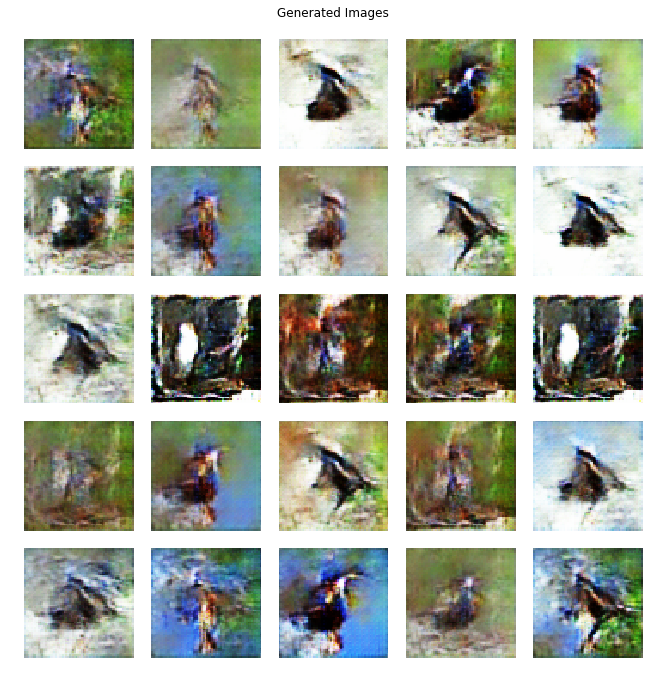

In [26]:
generated = netG(fixed_noise).detach().cpu().view(-1, 3, 64, 64)


grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1,
    normalize=True
)


plt.figure(figsize=(16, 12))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);
